在本次课程中，我们将讨论如何构建端到端模型。

In [1]:
from __future__ import annotations
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript

import IPython

加载数据集

作为一个具体的例子，我们将在 fashion MNIST 数据集上使用一个模型。 以下代码从 torchvision 下载并准备数据并转换成NumPy数组。

In [2]:
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

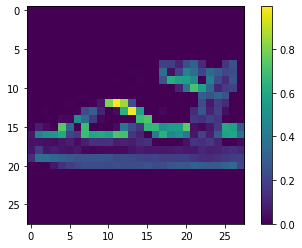

Class: Sandal


In [3]:
import matplotlib.pyplot as plt
# 绘制希望能够预测的图像
plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

# 端到端模型整合

在本章中，我们将使用以下模型作为示例。这是一个两层神经网络，由两个全连接层和一个有 relu 激活层组成。为了简化问题，我们删除了最终的 softmax 层。输出分数是未标准化的，但最大值仍然对应于最可能的类别。


![](../img/e2e_fashionmnist_mlp_model.png)


让我们从模型的 Numpy 实现开始。

In [4]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[ -5.339686   -14.9273615   -9.253113    -7.5942     -12.759898
    3.6109955   -2.4186068    0.63924587  -2.248192    -2.8493097 ]]
[5]
NumPy-MLP Prediction: Sandal


上面的示例代码显示了利用高层NumPy数组操作，执行端到端模型执行的过程。

回到 MLC 的视角中，我们希望了解这些数组计算的细节。

为了说明底层细节，我们将再次用底层 NumPy 编写示例：

- 我们将在使用循环而不是数组函数来演示循环计算。
- 我们总是通过 np.empty 显式分配数组并传递它们。（不包含数组初始化）
  
下面的代码展示了同一模型的底层 NumPy 实现：

In [5]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Sandal


### 在 TVMScript 中构建端到端 IRModule
考虑到低级 NumPy 示例，现在我们准备为端到端模型执行引入 MLC 抽象。 下面的代码块显示了模型的 TVMScript 实现。

有了底级 NumPy 代码作为参考，现在我们准备利用 MLC 抽象来实现端到端模型运行。下面的代码展示了模型的 TVMScript 实现。

In [6]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x : Tensor((1, 784),   "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128),     "float32"),
             w1: Tensor((10, 128),  "float32"),
             b1: Tensor((10),      "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0,   (lv0),       (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()